###  Libraries

In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_circles, make_moons
from sklearn.metrics.pairwise import pairwise_kernels
import math
import matplotlib.pyplot as plt

from tslearn.clustering import KernelKMeans
from InitialPartition import InitialPartition

### Global Variables

In [2]:
seed = 42

### Load Dataset

In [3]:
n_samples = 500

X, y = make_circles(n_samples=n_samples, factor=0.2, noise=0.05, random_state=seed)
len(np.where(np.array(y) == 1)[0])

# Find indices of samples with label 1
indices_label_1 = np.where(np.array(y) == 0)[0]

# Define the number of samples to remove
num_samples_to_remove = 0

# Randomly select indices to remove
indices_to_remove = np.random.choice(indices_label_1, size=num_samples_to_remove, replace=False)

# Remove selected samples
X = np.delete(X, indices_to_remove, axis=0)
y = np.delete(y, indices_to_remove)

# Number of samples after removal
print("Number of samples after removal:", len(X))
#X, y = make_moons(n_samples=n_samples, noise=0.1, random_state=seed)

Number of samples after removal: 500


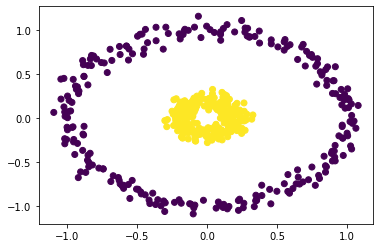

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y)

### We want a function that given the kernel and number of clusters to return me the initial partition using the kernel k-means++ algorithm

In [5]:
initialPartition = InitialPartition()

def find_cluster_indices(array, value):
    return np.where(np.array(array) == value)[0]

def custom_kernel_kmeans(X, centers_indices, initial_partition, kernel_matrix, max_iter=300, tol=1e-4):
    n_samples = X.shape[0]
    n_clusters = len(centers_indices)
    distances = np.zeros((n_clusters,n_samples))
    
    for iter in range(max_iter):
        
        for i in range(n_clusters):
            cluster_indices = find_cluster_indices(initial_partition, centers_indices[i])
            n_cluster_samples =  len(cluster_indices)
            stable_sum = (np.sum(kernel_matrix[k, l] for k in cluster_indices for l in cluster_indices)) / pow(n_cluster_samples, 2)
            
            for j in range(n_samples):
                sample_sum = np.sum(kernel_matrix[j,index] for index in cluster_indices) / n_cluster_samples
                distances[i,j] = kernel_matrix[j,j] - (2 * sample_sum) + stable_sum 
        
        min_distances = np.min(distances, axis=0)
        total_error = np.sum(min_distances)
        print(f"\n Total Error is: {total_error}!")
        
        next_partition = np.argmin(distances, axis=0)
        are_equal = np.array_equal(initial_partition, next_partition)
        if(are_equal):
            print(f"\n Finished in {iter} iterations!")
            return np.unique(next_partition), next_partition, total_error
        else:
            initial_partition = next_partition
            centers_indices = np.unique(next_partition)

# 6 are good
def kernel_kmeans_pp(X, K, kernel_matrix, n_init=6, method = 'KkMeans++'):
    min_total_error = math.inf

    for _ in range(n_init):
        centers_indices, partition = initialPartition.calculate_initial_partition(K, X, kernel_matrix, method)
        centers_indices, partition, total_error = custom_kernel_kmeans(X, centers_indices, initial_partition = partition, kernel_matrix=kernel_matrix, max_iter=300, tol=1e-4)
        print(f"\n centers_indices are: {centers_indices}!")
        if(total_error < min_total_error):
            min_total_error = total_error
            
            plt.scatter(X[:, 0], X[:, 1], c = partition)
            plt.show()

In [6]:
K = 2 
kernel_matrix = pairwise_kernels(X, X, metric='rbf', gamma=5)

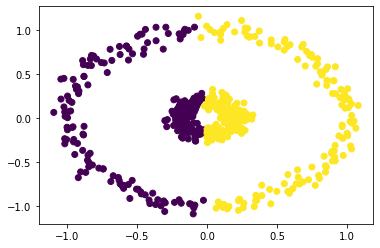

In [7]:
kmeans = KMeans(n_clusters=2).fit(X)
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)

/home/giorgos/anaconda3/lib/python3.9/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 500 1-dimensional timeseries
  warnings.warn(


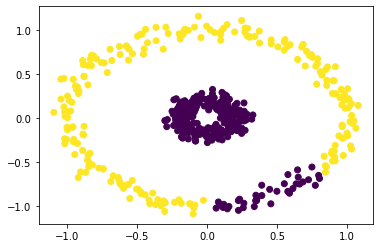

In [8]:
# Should find a way to init the fucking centers!
kernel_kmeans = KernelKMeans(n_clusters=2, n_init=1, kernel='precomputed').fit(kernel_matrix)
plt.scatter(X[:, 0], X[:, 1], c=kernel_kmeans.labels_)
plt.show()

Executing kMeans Initialization

 Total Error is: 359.1275192016967!

 Total Error is: 339.04732123775864!


/tmp/ipykernel_9633/52798685.py:16: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  stable_sum = (np.sum(kernel_matrix[k, l] for k in cluster_indices for l in cluster_indices)) / pow(n_cluster_samples, 2)
/tmp/ipykernel_9633/52798685.py:19: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sample_sum = np.sum(kernel_matrix[j,index] for index in cluster_indices) / n_cluster_samples



 Total Error is: 322.53101443319554!

 Total Error is: 298.67388305290694!

 Finished in 3 iterations!

 centers_indices are: [0 1]!


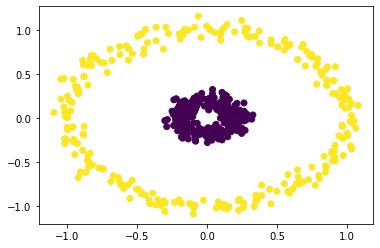

In [9]:
kernel_kmeans_pp(X, 2, kernel_matrix, n_init=1, method='kMeans')